📦 **Import libraries and set data directory**

In this step, we import the essential Python libraries used throughout the notebook and define the folder where all competition data files are stored.

* `pandas` and `numpy` are used for data manipulation
* `XGBRegressor` from XGBoost will serve as our baseline model
* `root_mean_squared_error` is used later for evaluation
* `DATA_DIR` points to the local folder where the Kaggle competition CSV files are located

Make sure the dataset files are downloaded and placed into this directory before running the notebook.


In [1]:
# ============================================
# Würzburg Retail Forecasting — Starter Notebook (XGBoost baseline)
# ============================================

import os
# from datetime import timedelta

import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor

DATA_DIR = "./data_kaggle_upload" # Set DATA_DIR = "path/to/your/files"


# Load all Data Files

📥 **Load all datasets**

In this step, we load all CSV files provided for the competition:

* **Core files**

  * `train.csv`: historical data with target values for model training
  * `test.csv`: rows for which we must generate predictions
  * `sample_submission.csv`: template that defines the submission format

* **Company metadata**

  * Store locations and closest pedestrian counters (`companyA_info`, `companyB_info`)
  * Opening hours of each store (`companyA_openingHours`, `companyB_openingHours`)

* **Pedestrian and weather data**

  * Historical foot traffic with weather (`2_pedestrians_weather_train.csv`)
  * Weather for validation/test period (`2_pedestrians_weather_val_test.csv`)
  * Forecasted pedestrian counts for val/test (`2_pedestrians_val_test_forecasts.csv`)
  * Locations of pedestrian counters (`2_pedestrians_counter_locations.csv`)

* **Contextual features**

  * Public holidays, school holidays, university lecture days, and city events

These datasets will later be merged with the main time series to build predictive features.


In [2]:
# -------------------------------
# Load Data
# -------------------------------

train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
submission_file = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

a_info = pd.read_csv(os.path.join(DATA_DIR, "1_companyA_info.csv"))
b_info = pd.read_csv(os.path.join(DATA_DIR, "1_companyB_info.csv"))
a_open = pd.read_csv(os.path.join(DATA_DIR, "1_companyA_openingHours.csv"))
b_open = pd.read_csv(os.path.join(DATA_DIR, "1_companyB_openingHours.csv"))

# Pedestrians & weather
pedestrians_train     = pd.read_csv(os.path.join(DATA_DIR, "2_pedestrians_weather_train.csv"))
pedestrians_valtest   = pd.read_csv(os.path.join(DATA_DIR, "2_pedestrians_weather_val_test.csv"))
pedestrians_forecasts = pd.read_csv(os.path.join(DATA_DIR, "2_pedestrians_val_test_forecasts.csv"))
pedestrians_loc       = pd.read_csv(os.path.join(DATA_DIR, "2_pedestrians_counter_locations.csv"))

# Holidays and Events
hol_public  = pd.read_csv(os.path.join(DATA_DIR, "3_bavarian_public_holidays_daily.csv"))
hol_school  = pd.read_csv(os.path.join(DATA_DIR, "3_bavarian_school_holidays_daily.csv"))
lectures    = pd.read_csv(os.path.join(DATA_DIR, "3_lectures_daily.csv"))
events_daily= pd.read_csv(os.path.join(DATA_DIR, "3_events_daily.csv"))
events_det  = pd.read_csv(os.path.join(DATA_DIR, "3_events_detailed.csv"))


In [3]:
train.head()

,id,company,category,date,hour,target
0,A_2022-01-03_7_customers,A,customers,2022-01-03,7,0.163866
1,A_2022-01-03_8_customers,A,customers,2022-01-03,8,0.197479
2,A_2022-01-03_9_customers,A,customers,2022-01-03,9,0.250000
3,A_2022-01-03_10_customers,A,customers,2022-01-03,10,0.315126
4,A_2022-01-03_11_customers,A,customers,2022-01-03,11,0.300420


In [4]:
test.head()

,id,company,category,date,hour
0,A_2024-11-25_7_customers,A,customers,2024-11-25,7
1,A_2024-11-25_8_customers,A,customers,2024-11-25,8
2,A_2024-11-25_9_customers,A,customers,2024-11-25,9
3,A_2024-11-25_10_customers,A,customers,2024-11-25,10
4,A_2024-11-25_11_customers,A,customers,2024-11-25,11


In [5]:
submission_file.head(12)

,id,target
0,A_2024-11-25_7_customers,0.252944
1,A_2024-11-25_8_customers,0.278037
2,A_2024-11-25_9_customers,0.314485
3,A_2024-11-25_10_customers,0.395188
4,A_2024-11-25_11_customers,0.435567
5,A_2024-11-25_12_customers,0.551742
6,A_2024-11-25_13_customers,0.551358
7,A_2024-11-25_14_customers,0.486172
8,A_2024-11-25_15_customers,0.500598
9,A_2024-11-25_16_customers,0.545423


# Descriptive Analytics

🕒 **Create a unified timestamp column**

The `train` and `test` datasets store the date and hour in separate columns.
To work efficiently with time series data, we combine them into a single `timestamp` column using `pd.to_datetime`.
This timestamp will be used later for sorting, filtering by time, and merging with other time-based datasets.


In [6]:
train["timestamp"] = pd.to_datetime(train["date"] + " " + train["hour"].astype(str) + ":00")
test["timestamp"]  = pd.to_datetime(test["date"]  + " " + test["hour"].astype(str)  + ":00")

train.head()

,id,company,category,date,hour,target,timestamp
0,A_2022-01-03_7_customers,A,customers,2022-01-03,7,0.163866,2022-01-03 07:00:00
1,A_2022-01-03_8_customers,A,customers,2022-01-03,8,0.197479,2022-01-03 08:00:00
2,A_2022-01-03_9_customers,A,customers,2022-01-03,9,0.250000,2022-01-03 09:00:00
3,A_2022-01-03_10_customers,A,customers,2022-01-03,10,0.315126,2022-01-03 10:00:00
4,A_2022-01-03_11_customers,A,customers,2022-01-03,11,0.300420,2022-01-03 11:00:00


📊 **Explore hourly patterns in the target variable**

To understand the daily behavior of customer counts and sales, we calculate the **average target value for each hour of the day**, grouped by company and product category.
This helps visualize whether there are specific peak business hours or differences across companies and categories.
The resulting line plot provides a first impression of the temporal structure in the data, which is useful for feature engineering and model design.


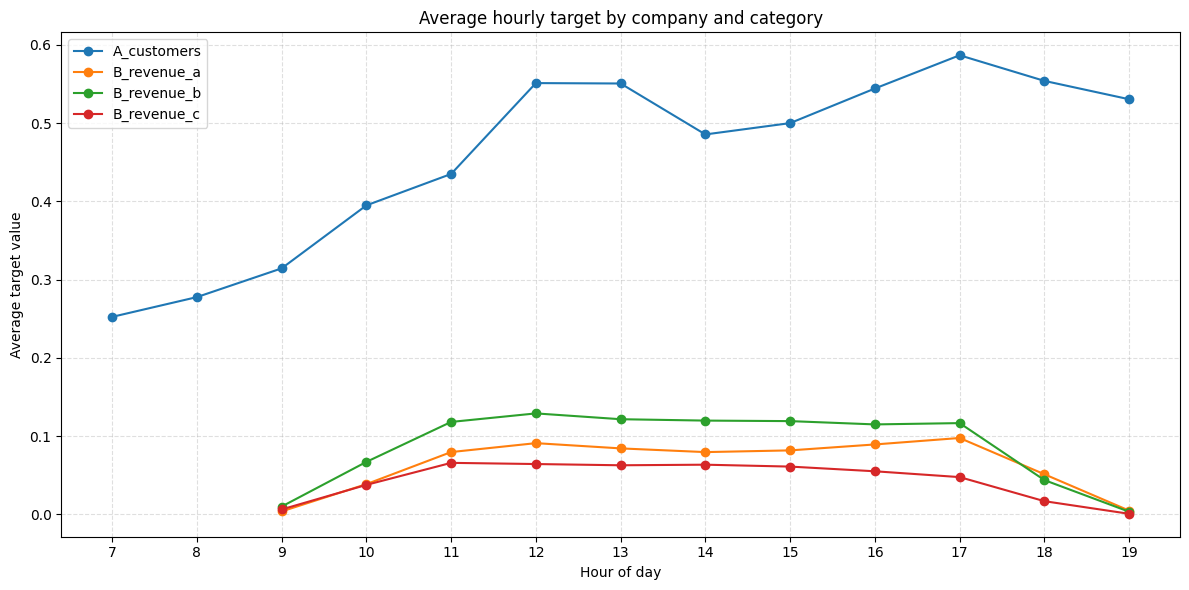

In [7]:
import matplotlib.pyplot as plt

# Group by company, category, and hour of day
hourly_pattern = (
    train.groupby(["company", "category", "hour"], as_index=False)["target"]
         .mean()
         .sort_values(["company", "category", "hour"])
)

# Plot
plt.figure(figsize=(12, 6))
for (comp, cat), grp in hourly_pattern.groupby(["company", "category"]):
    plt.plot(grp["hour"], grp["target"], marker="o", label=f"{comp}_{cat}")

plt.title("Average hourly target by company and category")
plt.xlabel("Hour of day")
plt.ylabel("Average target value")
plt.xticks(range(7, 20))
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


📆 **Visualize daily trends across companies and categories**

In this step, we analyze how the target values evolve **day by day**.
We first aggregate the hourly data into **daily averages** for each combination of company and category.
This smoother view helps us identify:

* Long-term trends (e.g. growth or decline over time)
* Seasonal effects or weekly cycles
* Differences in business behavior between the companies

The resulting line plot shows the daily dynamics and provides intuition for model design.


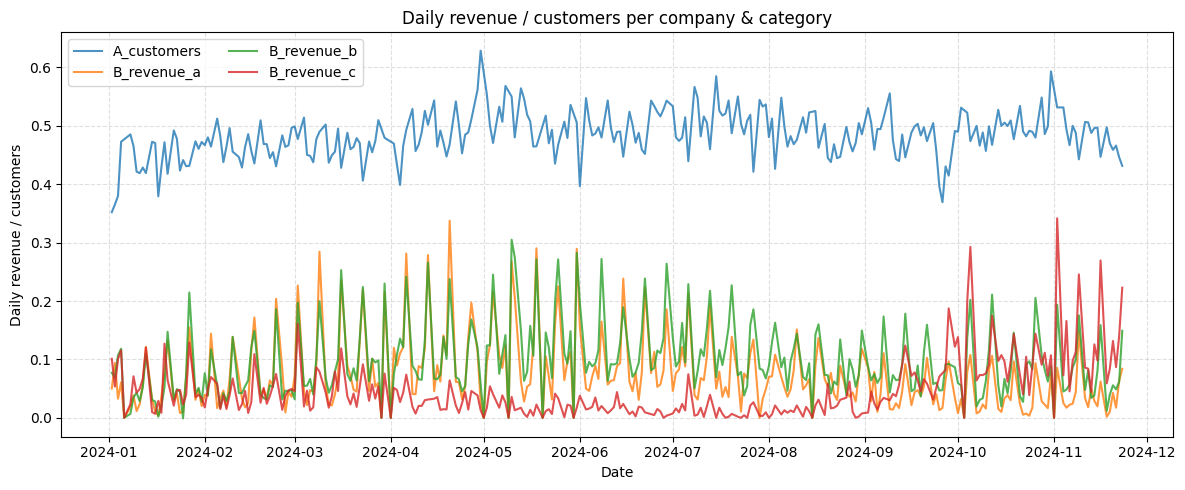

In [8]:
train_daily_base = train.copy()
train_daily_base["date"] = pd.to_datetime(train_daily_base["timestamp"]).dt.date

# ---- Aggregate per company & category per day ----

daily = (train_daily_base
         .groupby(["company", "category", "date"], as_index=False)
         .agg({"target": "mean"})
         .sort_values("date"))

daily = daily[daily.date >= pd.to_datetime("2024-01-01").date()]

# ---- Plot all four groups ----

plt.figure(figsize=(12, 5))

for (comp, cat), grp in daily.groupby(["company", "category"]):
    
    plt.plot(pd.to_datetime(grp["date"]), 
             grp["target"], 
             label=f"{comp}_{cat}",
             alpha=0.8)

plt.title(f"Daily revenue / customers per company & category")
plt.xlabel("Date")
plt.ylabel(f"Daily revenue / customers")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


In [9]:
# hourly = train.copy()
# hourly["date"] = pd.to_datetime(hourly["timestamp"]).dt.date


# hourly = hourly[(hourly.date >= pd.to_datetime("2024-08-01").date()) & (hourly.date <= pd.to_datetime("2024-08-31").date())]

# hourly.sort_values(["company", "category", "timestamp"])

# # ---- Plot all four groups ----
# plt.figure(figsize=(12, 5))
# for (comp, cat), grp in hourly.groupby(["company", "category"]):
#     plt.plot(pd.to_datetime(grp["timestamp"]), grp["target"], label=f"{comp}_{cat}")

# plt.title(f"Hourly revenue / customers per company & category")
# plt.xlabel("Date")
# plt.ylabel(f"Hourly revenue / customers")
# plt.grid(True, linestyle="--", alpha=0.4)
# plt.legend(ncol=2)
# plt.tight_layout()
# plt.show()

In [10]:
# # --- Build hourly slice ---
# hourly = train.copy()
# hourly["timestamp"] = pd.to_datetime(hourly["timestamp"])
# hourly["date"] = hourly["timestamp"].dt.date

# mask = (hourly["date"] >= pd.to_datetime("2024-08-01").date()) & \
#        (hourly["date"] <= pd.to_datetime("2024-08-31").date())
# hourly = hourly.loc[mask].copy()

# # --- Common full hourly index for the plotting window ---
# full_idx = pd.date_range(
#     hourly["timestamp"].min().floor("H"),
#     hourly["timestamp"].max().ceil("H"),
#     freq="h"
# )

# # --- Single combined plot with proper gaps ---
# plt.figure(figsize=(13, 5))
# for (comp, cat), grp in hourly.groupby(["company", "category"]):
#     g = grp[["timestamp", "target"]].set_index("timestamp").sort_index()
#     g = g.reindex(full_idx)  # insert missing hours as NaN → creates visible gaps
#     plt.plot(
#         g.index, g["target"],
#         label=f"{comp}_{cat}",
#         marker="o", markersize=2, linewidth=1, alpha=0.9
#     )

# plt.title("Hourly revenue/customers per company & category (gaps where no data)")
# plt.xlabel("Date")
# plt.ylabel("Hourly target")
# plt.grid(True, linestyle="--", alpha=0.4)
# plt.legend(ncol=2)
# plt.tight_layout()
# plt.show()


# Data Engineering

🧭 **Add basic time-based features**

This helper function extracts useful calendar information from the timestamp, which helps the model learn temporal patterns:

* `day_of_week`: weekday (0 = Monday, ..., 6 = Sunday)
* `hour`: hour of the day
* `is_weekend`: indicator for weekends
* `day`, `month`: calendar day and month
* `weekofyear`: weekly seasonal structure

These features encode time patterns such as rush hours, weekday effects, and weekly seasonality, which are important in time series forecasting.


In [11]:
def add_time_features(df):

    ts = df["timestamp"]
    df["day_of_week"] = ts.dt.weekday          # 0=Mon
    df["hour"] = ts.dt.hour            # already present, but ensure int
    df["is_weekend"] = (df["day_of_week"]>=5).astype(int)
    df["day"] = ts.dt.day
    df["month"] = ts.dt.month
    df["weekofyear"] = ts.dt.isocalendar().week.astype(int)
    return df

train = add_time_features(train)
test = add_time_features(test)

train.head()

,id,company,category,date,hour,target,timestamp,day_of_week,is_weekend,day,month,weekofyear
0,A_2022-01-03_7_customers,A,customers,2022-01-03,7,0.163866,2022-01-03 07:00:00,0,0,3,1,1
1,A_2022-01-03_8_customers,A,customers,2022-01-03,8,0.197479,2022-01-03 08:00:00,0,0,3,1,1
2,A_2022-01-03_9_customers,A,customers,2022-01-03,9,0.250000,2022-01-03 09:00:00,0,0,3,1,1
3,A_2022-01-03_10_customers,A,customers,2022-01-03,10,0.315126,2022-01-03 10:00:00,0,0,3,1,1
4,A_2022-01-03_11_customers,A,customers,2022-01-03,11,0.300420,2022-01-03 11:00:00,0,0,3,1,1


🏫 **Add school holiday information**

School holidays can strongly influence shopping behavior and city activity.
Here, we merge the **Bavarian school holiday calendar** (`hol_school`) into both the training and test data using the date as the key.
This adds a binary feature that indicates whether a given day falls within a school holiday period, helping the model capture relevant demand fluctuations.


In [12]:
# Merge hol_school to train and test
train = train.merge(hol_school, how="left", left_on="date", right_on="date")
test = test.merge(hol_school, how="left", left_on="date", right_on="date")

In [13]:
train.head()

,id,company,category,date,hour,target,timestamp,day_of_week,is_weekend,day,month,weekofyear,school_holiday
0,A_2022-01-03_7_customers,A,customers,2022-01-03,7,0.163866,2022-01-03 07:00:00,0,0,3,1,1,1
1,A_2022-01-03_8_customers,A,customers,2022-01-03,8,0.197479,2022-01-03 08:00:00,0,0,3,1,1,1
2,A_2022-01-03_9_customers,A,customers,2022-01-03,9,0.250000,2022-01-03 09:00:00,0,0,3,1,1,1
3,A_2022-01-03_10_customers,A,customers,2022-01-03,10,0.315126,2022-01-03 10:00:00,0,0,3,1,1,1
4,A_2022-01-03_11_customers,A,customers,2022-01-03,11,0.300420,2022-01-03 11:00:00,0,0,3,1,1,1


In [15]:
test.head()

,id,company,category,date,hour,timestamp,day_of_week,is_weekend,day,month,weekofyear,school_holiday
0,A_2024-11-25_7_customers,A,customers,2024-11-25,7,2024-11-25 07:00:00,0,0,25,11,48,0
1,A_2024-11-25_8_customers,A,customers,2024-11-25,8,2024-11-25 08:00:00,0,0,25,11,48,0
2,A_2024-11-25_9_customers,A,customers,2024-11-25,9,2024-11-25 09:00:00,0,0,25,11,48,0
3,A_2024-11-25_10_customers,A,customers,2024-11-25,10,2024-11-25 10:00:00,0,0,25,11,48,0
4,A_2024-11-25_11_customers,A,customers,2024-11-25,11,2024-11-25 11:00:00,0,0,25,11,48,0


# Train a Machine Learning Model

🏪 **Prepare training data for Company A**

To start modeling, we focus first on **Company A**.
We filter the full dataset to include only rows that belong to Company A and then:

* Separate the **features** (`X_train_A`, `X_test_A`) from the **target variable** (`y_train_A`)
* Drop unnecessary columns such as IDs, static metadata, and timestamps that are no longer needed after feature extraction

This results in clean training and test matrices that are ready for model input.


In [16]:
train_A = train[train["company"] == "A"].copy()
test_A = test[test["company"] == "A"].copy()

X_train_A = train_A.drop(columns=["id", "company", "category", "target", "date", "timestamp"])
y_train_A = train_A["target"]
X_test_A = test_A.drop(columns=["id", "company", "category", "date", "timestamp"])

In [18]:
train_A

,id,company,category,date,hour,target,timestamp,day_of_week,is_weekend,day,month,weekofyear,school_holiday
0,A_2022-01-03_7_customers,A,customers,2022-01-03,7,0.163866,2022-01-03 07:00:00,0,0,3,1,1,1
1,A_2022-01-03_8_customers,A,customers,2022-01-03,8,0.197479,2022-01-03 08:00:00,0,0,3,1,1,1
2,A_2022-01-03_9_customers,A,customers,2022-01-03,9,0.250000,2022-01-03 09:00:00,0,0,3,1,1,1
3,A_2022-01-03_10_customers,A,customers,2022-01-03,10,0.315126,2022-01-03 10:00:00,0,0,3,1,1,1
4,A_2022-01-03_11_customers,A,customers,2022-01-03,11,0.300420,2022-01-03 11:00:00,0,0,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11344,A_2024-11-23_15_customers,A,customers,2024-11-23,15,0.584034,2024-11-23 15:00:00,5,1,23,11,47,0
11345,A_2024-11-23_16_customers,A,customers,2024-11-23,16,0.548319,2024-11-23 16:00:00,5,1,23,11,47,0
11346,A_2024-11-23_17_customers,A,customers,2024-11-23,17,0.628151,2024-11-23 17:00:00,5,1,23,11,47,0
11347,A_2024-11-23_18_customers,A,customers,2024-11-23,18,0.626050,2024-11-23 18:00:00,5,1,23,11,47,0


🤖 **Train a baseline XGBoost model for Company A**

We train a first forecasting model using **XGBoost**, a powerful tree-based gradient boosting algorithm that performs well on tabular data.

* The model learns to map engineered features to the target demand values.
* After training, we generate predictions:

  * `preds_train_A` – predictions on the training set (for comparison with actuals)
  * `preds_test_A` – predictions for the Kaggle test set (for submission later)

The predictions are added back into `train_A` and `test_A` so they can be visualized and used for submission.


In [23]:
X_train_A

,hour,day_of_week,is_weekend,day,month,weekofyear,school_holiday
0,7,0,0,3,1,1,1
1,8,0,0,3,1,1,1
2,9,0,0,3,1,1,1
3,10,0,0,3,1,1,1
4,11,0,0,3,1,1,1
...,...,...,...,...,...,...,...
11344,15,5,1,23,11,47,0
11345,16,5,1,23,11,47,0
11346,17,5,1,23,11,47,0
11347,18,5,1,23,11,47,0


In [24]:
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=1
)

In [25]:
model.fit(X_train_A, y_train_A)

preds_train_A = model.predict(X_train_A)
preds_test_A = model.predict(X_test_A)

# Add predictions to train and test for Company A
train_A["pred"] = preds_train_A
test_A["pred"] = preds_test_A

## Plot Predictions

🧱 **Helper function to create a continuous hourly time series**

The raw data does not include entries for every hour (e.g. during closing hours), which makes time series plots look broken.
This function fills the timeline by:

* Expanding the index to include **every hour** within a given time window
* **Reindexing** the data to this full hourly grid
* **Filling missing target and prediction values with zeros**, which is reasonable outside opening hours
* Forward-filling static columns like `company` and `category`

This creates a smooth time index for cleaner visualizations and consistent time-based processing.


In [26]:
# ---- HELPER FUNCTION TO EXPAND TO FULL HOURLY GRID ----

def expand_hourly(df, start_time=None, end_time=None):
    """
    Expand a dataframe to a full hourly time index (continuous),
    filling missing rows with zeros for target and prediction.
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.set_index("timestamp")

    # Create the full hourly index
    full_index = pd.date_range(
        start=start_time or df.index.min(),
        end=end_time or df.index.max(),
        freq="h"
    )

    # Reindex to full hourly resolution and fill missing with zeros
    df = df.reindex(full_index)

    # Preserve other columns by forward fill or constant fill
    if "company" in df.columns:
        df["company"] = df["company"].ffill()
    if "category" in df.columns:
        df["category"] = df["category"].ffill()

    # Fill target/prediction NaNs with zeros
    if "target" in df.columns:
        df["target"] = df["target"].fillna(0)
    if "pred" in df.columns:
        df["pred"] = df["pred"].fillna(0)

    # Restore timestamp as a column
    df = df.reset_index().rename(columns={"index": "timestamp"})
    return df

📈 **Visualize predictions for Company A over time**

To better understand how well the model performs, we create a **continuous hourly timeline** for Company A and plot:

* **Actual target values** from the last days of the training period
* **Model predictions** on the same time range
* **Predictions on the full test period**

Missing hours were filled with zeros earlier so that the time axis is continuous and easier to read.
The red vertical line marks the **boundary between training and test periods**, helping to distinguish historical data from the prediction horizon.


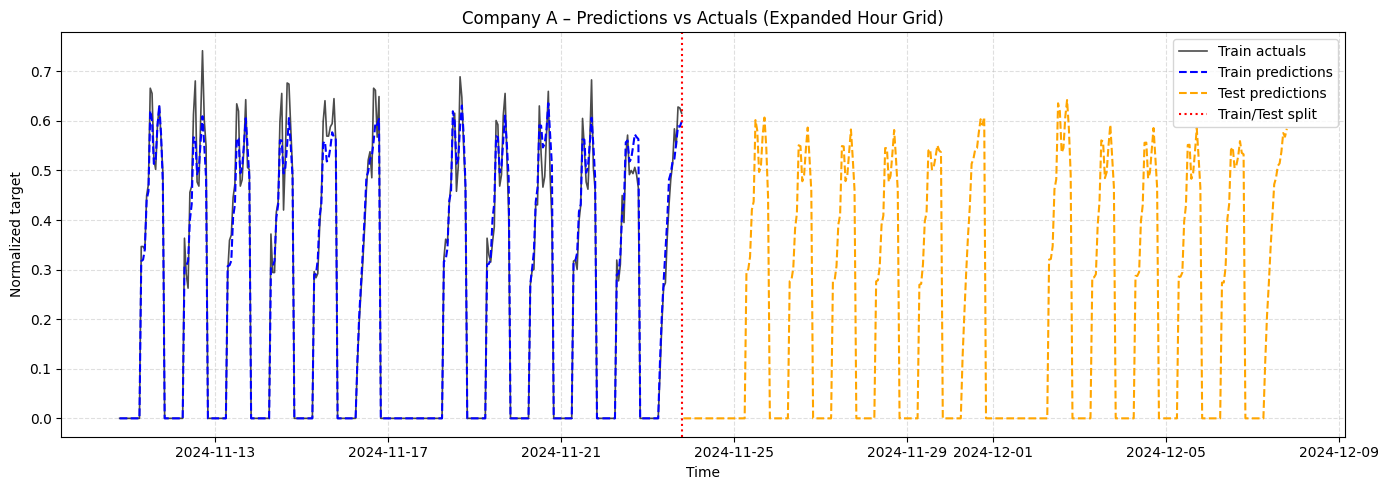

In [27]:
# Expand train and test for Company A
train_A_expanded = expand_hourly(train_A, 
                                 start_time=train_A["timestamp"].min(), 
                                 end_time=train_A["timestamp"].max())

test_A_expanded  = expand_hourly(test_A,  
                                 start_time=train_A["timestamp"].max() + pd.Timedelta(hours=1),
                                 end_time=test_A["timestamp"].max())


plt.figure(figsize=(14, 5))

# Last week of expanded training data
last_week_mask = train_A_expanded["timestamp"] >= (train_A_expanded["timestamp"].max() - pd.Timedelta(days=13))
train_last_week_expanded = train_A_expanded[last_week_mask]

# Plot
plt.plot(train_last_week_expanded["timestamp"], train_last_week_expanded["target"],
         label="Train actuals", 
         color="black", 
         linewidth=1.2, 
         alpha=0.7)

plt.plot(train_last_week_expanded["timestamp"], 
         train_last_week_expanded["pred"],
         label="Train predictions", 
         linestyle="--", 
         color="blue")

plt.plot(test_A_expanded["timestamp"], 
         test_A_expanded["pred"],
         label="Test predictions", 
         linestyle="--", 
         color="orange")

plt.axvline(x=train_last_week_expanded["timestamp"].max(), color="red", linestyle=":", label="Train/Test split")

plt.title("Company A – Predictions vs Actuals (Expanded Hour Grid)")
plt.xlabel("Time")
plt.ylabel("Normalized target")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


## Out-Of-Sample Evaluation

🧪 **Create a validation split for Company A (out-of-sample test)**

To properly evaluate the model, we simulate future forecasting by holding out the **last days of the training data** as a **validation set**:

* `train_A`: contains the historical data **excluding the last few days**
* `val_A`: contains the **most recent days**, which we treat like unseen future data

We then split both into features (`X_train_A`, `X_val_A`) and target values (`y_train_A`, `y_val_A`).
This setup allows us to evaluate how well the model generalizes to unseen time periods before using it on the real test set.


In [28]:
train_A = train[train["company"] == "A"].copy()
val_A = train[train["company"] == "A"].copy()

# Remove the last week of training data for out-of-sample evaluation
train_A = train_A[train_A["timestamp"] <= (train_A["timestamp"].max() - pd.Timedelta(days=5)) - pd.Timedelta(hours=23)]
val_A = val_A[val_A["timestamp"] > (train_A["timestamp"].max())]

X_train_A = train_A.drop(columns=["id", "company", "category", "target", "date", "timestamp"])
y_train_A = train_A["target"]

X_val_A = val_A.drop(columns=["id", "company", "category", "target", "date", "timestamp"])
y_val_A = val_A["target"]

In [29]:
train_A.tail()

,id,company,category,date,hour,target,timestamp,day_of_week,is_weekend,day,month,weekofyear,school_holiday
11266,A_2024-11-16_15_customers,A,customers,2024-11-16,15,0.485294,2024-11-16 15:00:00,5,1,16,11,46,0
11267,A_2024-11-16_16_customers,A,customers,2024-11-16,16,0.665966,2024-11-16 16:00:00,5,1,16,11,46,0
11268,A_2024-11-16_17_customers,A,customers,2024-11-16,17,0.661765,2024-11-16 17:00:00,5,1,16,11,46,0
11269,A_2024-11-16_18_customers,A,customers,2024-11-16,18,0.567227,2024-11-16 18:00:00,5,1,16,11,46,0
11270,A_2024-11-16_19_customers,A,customers,2024-11-16,19,0.649160,2024-11-16 19:00:00,5,1,16,11,46,0


⚙️ **Train XGBoost and generate validation predictions**

We now train the XGBoost model again, this time using only the **training portion** of Company A's data (excluding the validation period). After fitting the model:

* We generate predictions for the **training set** (`preds_train_A`) to check for overfitting.
* We also predict on the **validation set** (`preds_val_A`) to measure **out-of-sample performance**.

The predictions are added back to `train_A` and `val_A` for later visualization and error analysis.


In [30]:
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=1
)

model.fit(X_train_A, y_train_A)

preds_train_A = model.predict(X_train_A)
preds_val_A = model.predict(X_val_A)

# Add predictions to train and val for Company A
train_A["pred"] = preds_train_A
val_A["pred"] = preds_val_A

📏 **Evaluate model performance with RMSE**

We evaluate how well the model fits the data using **Root Mean Squared Error (RMSE)**:

* `Train RMSE` shows how closely the model fits the training data.
* `Validation RMSE` indicates how well the model generalizes to unseen future data.

A much lower training error compared to validation error would suggest **overfitting**, while similar values indicate good generalization.


In [31]:
# Calculate RMSE on train and validation set
rmse_train_A = np.sqrt(root_mean_squared_error(y_train_A, preds_train_A))
rmse_val_A = np.sqrt(root_mean_squared_error(y_val_A, preds_val_A))

print(f"Train RMSE: {rmse_train_A:.4f}")
print(f"Validation RMSE: {rmse_val_A:.4f}")

Train RMSE: 0.2232
Validation RMSE: 0.2417


📉 **Compare predictions with actuals on train and validation periods**

To visually assess model performance, we plot the **true target values** and **model predictions** for Company A over time:

* The **black lines** show actual values from the training and validation periods.
* The **dashed lines** show the model’s predictions.
* Missing hours have been filled so the timeline is continuous.
* The **red vertical line** marks the transition between the training data and the held-out validation period.

This plot helps diagnose whether the model correctly captures time dynamics or lags, reacts to peaks, and transitions smoothly into the forecast horizon.


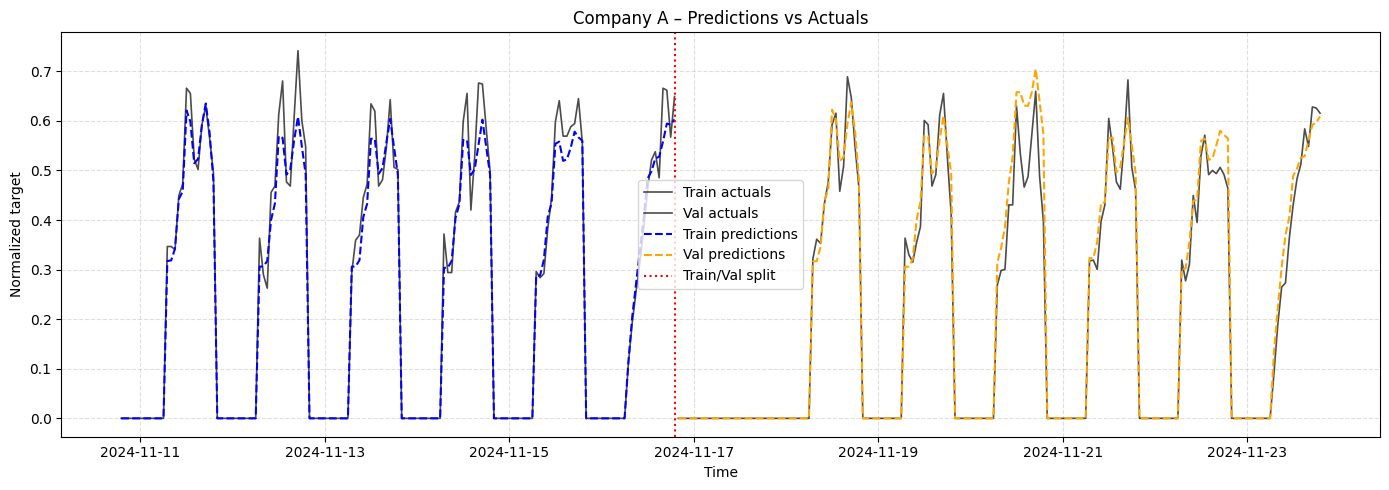

In [32]:
# Expand train and test for Company A
train_A_expanded = expand_hourly(train_A, 
                                 start_time=train_A["timestamp"].min(), 
                                 end_time=train_A["timestamp"].max())

val_A_expanded  = expand_hourly(val_A,  
                                start_time=train_A["timestamp"].max() + pd.Timedelta(hours=1),
                                end_time=val_A["timestamp"].max())


plt.figure(figsize=(14, 5))

# Last week of expanded training data
last_week_mask = train_A_expanded["timestamp"] >= (train_A_expanded["timestamp"].max() - pd.Timedelta(days=6))
train_last_week_expanded = train_A_expanded[last_week_mask]

# Plot
plt.plot(train_last_week_expanded["timestamp"], train_last_week_expanded["target"],
         label="Train actuals", 
         color="black", 
         linewidth=1.2, 
         alpha=0.7)

plt.plot(val_A_expanded["timestamp"], val_A_expanded["target"],
         label="Val actuals", 
         color="black", 
         linewidth=1.2, 
         alpha=0.7)

plt.plot(train_last_week_expanded["timestamp"], train_last_week_expanded["pred"],
         label="Train predictions", 
         linestyle="--", 
         color="blue")

plt.plot(val_A_expanded["timestamp"], val_A_expanded["pred"],
         label="Val predictions", 
         linestyle="--", 
         color="orange")

plt.axvline(x=train_last_week_expanded["timestamp"].max(), color="red", linestyle=":", label="Train/Val split")

plt.title("Company A – Predictions vs Actuals")
plt.xlabel("Time")
plt.ylabel("Normalized target")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
